Baird Counter Example
---
To convert them to semi-gradient form, we simply replace the update to an array `(V or Q)` to an update to a weight vector `(w)`, using the approximate value function (`vˆ` or `qˆ`) and its gradient. Many of these algorithms use the per-step `importance sampling ratio` (importance weight):

<img src="rho.png" width="200">

<img src="weights_update.png" width="300">

---
The dashed action takes the system to one of the six upper states with equal probability, whereas the solid action takes the system to the seventh state. The `behavior policy b` selects the dashed and solid actions with probabilities `6/7` and `1/7`, so that the next-state distribution under it is uniform (the same for all nonterminal states), which is also the starting distribution for each episode. The target policy `π` always takes the solid action, and so the on-policy distribution (for `π`) is concentrated in the seventh state. The reward is `zero` on all transitions. The discount rate is `γ = 0.99`.

<img src="Baird.png" width="600">

- [Target Policy & Behaviour Policy](https://stats.stackexchange.com/questions/410131/in-rl-why-using-a-behavior-policy-instead-of-the-target-policy-for-an-episode-i)
- [Target Policy & Behaviour Policy2](https://stats.stackexchange.com/questions/237085/how-to-correctly-compute-rho-in-reinforcement-learning-with-importance-sampli?rq=1)

---
## TDC
<img src="TDC.png" width=300>
<img src="TDC_v.png" width=300>

which again is O(d) if the final product (xt*vt) is done first. This algorithm is known as either TD(0) with gradient correction (TDC) or, alternatively, as GTD(0).

In [1]:
import numpy as np

In [12]:
STATES = range(7)

In [115]:
class Baird:
    
    def __init__(self, gamma=0.99, alpha=0.01):
        self.state = np.random.choice(STATES)
        self.prob = 1.0/7
        self.actions = ["solid", "dash"]
        self.gamma = gamma
        self.alpha = alpha
        
        self.features = np.zeros((len(STATES), 8))  # n_states x n_weights (this is the representation of states)
        for i in range(len(STATES)):
            if i == 6:
                self.features[i, -2] = 1
                self.features[i, -1] = 2
            else:
                self.features[i, i] = 2
                self.features[i, -1] = 1
        
        self.weights = np.ones(8)
        self.weights[-2] = 10
        
    def chooseAction(self):
        if np.random.binomial(1, self.prob) == 1:
            action = "solid"
        else:
            action = "dash"
        return action
    
    def takeAction(self, action):
        if action == "solid":
            nxtState = 6
        else:
            nxtState = np.random.choice(STATES[:-1])
        return nxtState
    
    def value(self, state):
        v = np.dot(ba.features[state, :], ba.weights)
        return v
    
    def run_semi_gradient_TD(self, rounds=100, sarsa=False):
        reward = 0
        
        step_weights = np.zeros((rounds, len(self.weights)))
        for i in range(rounds):
            step_weights[i, :] = self.weights
            action = self.chooseAction()
            nxtState = self.takeAction(action)
            
            if action == "dash":
                rho = 0
            else:
                rho = 1/self.prob
            
            if sarsa:
                rho = 1
            
            delta = reward + self.gamma*self.value(nxtState) - self.value(self.state)
            delta *= self.alpha*rho
            # update
            self.weights += delta*self.features[state, :]
                        
            self.state = nxtState
        return step_weights
    
    def run_TDC(self, beta=0.01, rounds=100):
        reward = 0
        v = np.zeros(8)
        
        step_weights = np.zeros((rounds, len(self.weights)))
        for i in range(rounds):
            step_weights[i, :] = self.weights
            action = self.chooseAction()
            nxtState = self.takeAction(action)
            
            if action == "dash":
                rho = 0
            else:
                rho = 1/self.prob
            
            delta = reward + self.gamma*self.value(nxtState) - self.value(self.state)
            self.weights += self.alpha*rho*(delta*self.features[self.state, :] - 
                                            self.gamma*self.features[nxtState, :]*np.dot(self.features[self.state, :], v))
            v += beta*rho*(delta - np.dot(v, self.features[self.state, :]))*self.features[self.state, :]
            
            self.state = nxtState
        print("last v \n", v)
        return step_weights

In [104]:
ba = Baird()
print(ba.features)
print()
print(ba.weights)

[[2. 0. 0. 0. 0. 0. 0. 1.]
 [0. 2. 0. 0. 0. 0. 0. 1.]
 [0. 0. 2. 0. 0. 0. 0. 1.]
 [0. 0. 0. 2. 0. 0. 0. 1.]
 [0. 0. 0. 0. 2. 0. 0. 1.]
 [0. 0. 0. 0. 0. 2. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 2.]]

[ 1.  1.  1.  1.  1.  1. 10.  1.]


### Semi-gradient TD

In [100]:
ba = Baird()
step_weigts_q = ba.run_semi_gradient_TD(rounds=1000)

In [101]:
ba = Baird()
step_weigts_sarsa = ba.run_semi_gradient_TD(rounds=1000, sarsa=True)

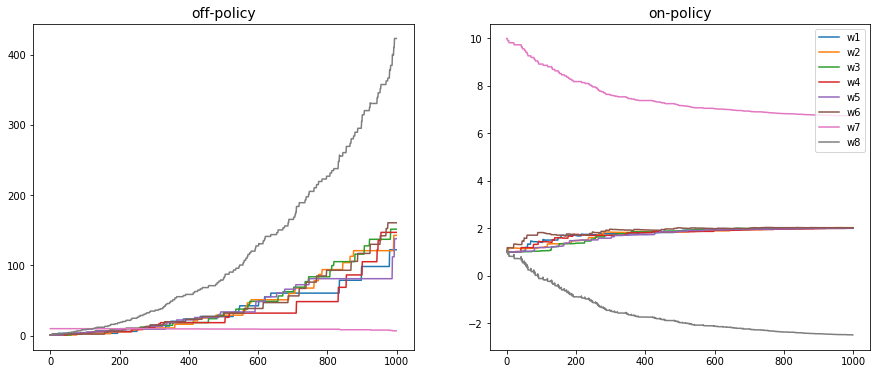

In [102]:
plt.figure(figsize=[15, 6])

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

row, col = step_weigts_q.shape
for i in range(col):
    ax1.plot(range(row), step_weigts_q[:, i], label="w{}".format(i+1))
    ax2.plot(range(row), step_weigts_sarsa[:, i], label="w{}".format(i+1))

ax1.set_title("off-policy", size=14)
ax2.set_title("on-policy", size=14)
plt.legend()

### TDC

In [123]:
ba = Baird(alpha=0.005)
step_weigts_tdc = ba.run_TDC(rounds=1000, beta=0.05)

last v 
 [-0.03695354  0.02034874 -0.00248629  0.03586568 -0.01377544 -0.00124259
 -0.00417839 -0.0074785 ]


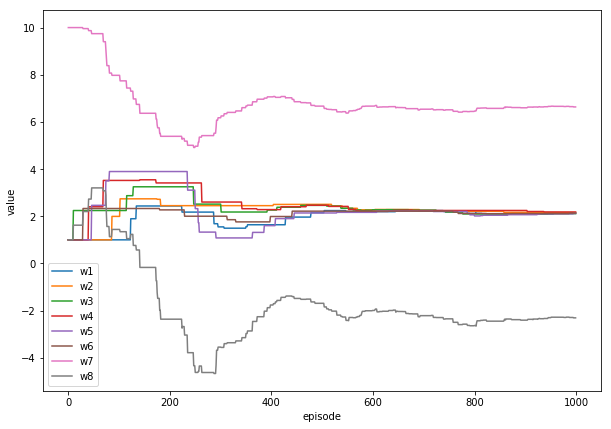

In [124]:
plt.figure(figsize=[10, 7])

row, col = step_weigts_tdc.shape

for i in range(col):
    plt.plot(range(row), step_weigts_q[:, i], label="w{}".format(i+1))

plt.xlabel("episode")
plt.ylabel("value")
plt.legend()